## Introduction

If there are few (typically 2) ways of using the word in a sentence and only one of them is correct, we call it an _alternative problem_, and the word we call _problematic word_. The typical example in English language is whether to write the ending -s to the verb: "I see", but "she sees". In Russian, these alternative problems are much more present and deserve their own codebase.

The approach is to take the correct sentences, replace the problematic words with their counterparts, thus building negative samples. Also, when doing it, we want to balance the sentences by corpus and by length, as these factors often affect the performance. Finally, when we merge the data from different corpora, we want to update `sentence_id`, `word_id` and `paragraph_id`, as those must be unique in the dataset.


## TSA 

TSA is an alternative problem where verbs have similar but different endings in invinitive (ться) and finite form (тся). No all the verbs are like this (e.g. нравится/нравиться, but хочется/хотеться), so first we need to filter the verbs that are _problematic_.

### Creating dictionary


First, let's define the list of corpora we will use in our bundle. Assume we have three corpora: news, publicistics and books.

In [1]:
from tg.grammar_ru import Loc

corpora = [
#    Loc.corpus_path/'books.base.zip',
#    Loc.corpus_path/'pub.base.zip',
    Loc.corpus_path/'lenta.base.zip',
]

Not every sentence in the corpora contains problematic word, so first we need to detect the sentences that are required in the bundle. For this particular task we will use a dictionary approach: we will scan the corpora and find verbs that are presented there in both -тся and -ться forms.

In [2]:
from yo_fluq_ds import *

good_words = set(FileIO.read_json('tsa-dict.json'))
list(good_words)[:5]

['оправиться', 'изводиться', 'сговориться', 'отмахнуться', 'нереститься']

## Balancing dataset


We want an equal representation of the sentences of different lengths, as well as sentences from different corpora. To do this, we will scan the corpora again, consider only the sentences that have a problematic word, and then compute the length of each such sentence.

In [3]:
from tg.grammar_ru.corpus import BucketBalancer, CorpusReader
from pathlib import Path

buckets_path = Path('tsa-buckets.parquet')

if True or not buckets_path.is_file():
    en = CorpusReader.read_frames_from_several_corpora(corpora).feed(fluq.with_progress_bar()).select(tsa_filter.filter)
    buckets_df = BucketBalancer.collect_buckets(en)
    buckets_df.to_parquet(buckets_path)
else:
    buckets_df = pd.read_parquet(buckets_path)


  0%|          | 0/988 [00:00<?, ?it/s]

NameError: name 'tsa_filter' is not defined

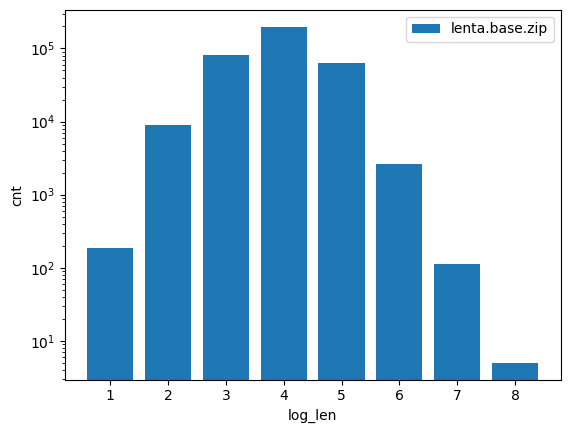

In [8]:
from tg.common.analysis import grbar_plot

ax = grbar_plot(
    buckets_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.set_yscale('log')
ax.legend()


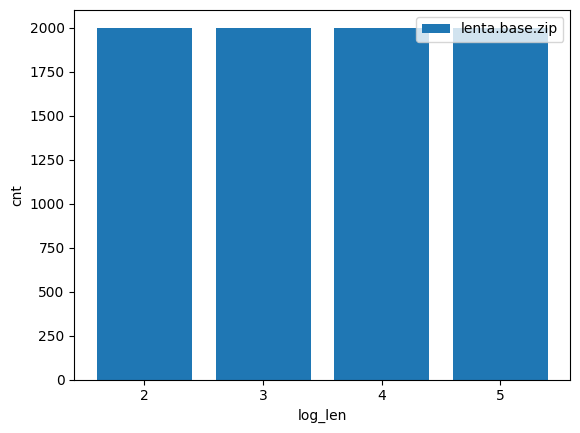

In [9]:
import numpy as np
take_df = buckets_df
take_df['random'] = np.random.rand(take_df.shape[0])
take_df = take_df.feed(fluq.add_ordering_column(['corpus_id','log_len'],'random'))
take_df = take_df.loc[(take_df.order<2000) & take_df.log_len.between(2,5)]


ax = grbar_plot(
    take_df.groupby(['corpus_id','log_len']).size().to_frame('cnt').reset_index(),
    value_column='cnt',
    color_column='corpus_id',
    group_column='log_len'
)
ax.legend()


Let's convert `take_df` into simpler format for `BucketBalancer`, and create a balancer:

In [10]:
tsa_balancer = BucketBalancer(BucketBalancer.buckets_statistics_to_dict(take_df))
str(tsa_balancer.buckets)[:100]

"{'lenta.base.zip': {5341187, 125894670, 11042843, 72613916, 95715359, 148668449, 147456035, 36044836"

At this point, we are ready to perform transfusion. Transfusion is an operation that reads the corpora, samples the sentences and creates a new corpus with these selected sentences. Along the way it also correct all the ids, thus making sure the merged corpus is consistant.


In [11]:
from tg.projects.alternative import AlternativeTaskTransfuseSelector
from tg.grammar_ru.corpus import CorpusBuilder
from tg.common import Logger

Logger.disable()

selector = AlternativeTaskTransfuseSelector(
    tsa_balancer,
    tsa_filter,
    tsa_sampler
)

tsa_transfused = Loc.temp_path/'demos/bundle/tsa.transfused.zip'

CorpusBuilder.transfuse_corpus(
    sources = corpora,
    destination = tsa_transfused,
    selector = selector,
    #words_limit=10000,
    words_per_frame = 10000,
    overwrite = True
)

In [12]:
from tg.grammar_ru import CorpusReader

CorpusReader(tsa_transfused).get_toc()

,filename,timestamp,part_index,token_count,character_count,ordinal,max_id
file_id,,,,,,,
081ee02f-b6fe-47c3-b0d7-9cd5f09811c3,,2023-07-12 21:24:46.528358,0,9945,52147,0,10683
a3b332cf-872b-41b7-b93e-213a4656e0db,,2023-07-12 21:24:49.353324,1,9994,52101,1,21260
504f3c5b-5ac2-4956-842c-78d65446570f,,2023-07-12 21:24:52.557291,2,9998,52806,2,31951
c3bbb02d-e7b7-4426-97f9-4aea4dbe42b7,,2023-07-12 21:24:55.716790,3,9988,53129,3,42610
169db8ac-d5a6-4f99-a23e-91df81027c52,,2023-07-12 21:24:59.263487,4,9984,52483,4,53331
12c9d79c-1fed-43a4-b143-12206f5c3d77,,2023-07-12 21:25:02.905351,5,9972,53908,5,64084
d432617a-29fc-4072-8b70-7a0cc8f50292,,2023-07-12 21:25:06.070517,6,9972,52300,6,74738
86f5280d-4897-4af1-a193-11d19991ef14,,2023-07-12 21:25:09.577663,7,9979,53834,7,85520
48751eec-9bc6-490a-b5c8-e6fec882fa8a,,2023-07-12 21:25:13.541058,8,9999,53222,8,96377


In [13]:
CorpusReader(tsa_transfused).get_frames().first().head()

,word_id,sentence_id,word_index,paragraph_id,word_tail,word,word_type,word_length,file_id,corpus_id,is_target,label,original_corpus,original_word_id,original_sentence_id,original_paragraph_id,updated
0,0,0,0,0,1,Акция,ru,5,081ee02f-b6fe-47c3-b0d7-9cd5f09811c3,tsa.transfused.zip,False,0,lenta.base.zip,63561,3406,630,False
1,1,0,1,0,1,проводится,ru,10,081ee02f-b6fe-47c3-b0d7-9cd5f09811c3,tsa.transfused.zip,True,0,lenta.base.zip,63562,3406,630,False
2,2,0,2,0,1,под,ru,3,081ee02f-b6fe-47c3-b0d7-9cd5f09811c3,tsa.transfused.zip,False,0,lenta.base.zip,63563,3406,630,False
3,3,0,3,0,1,хештегом,ru,8,081ee02f-b6fe-47c3-b0d7-9cd5f09811c3,tsa.transfused.zip,False,0,lenta.base.zip,63564,3406,630,False
4,4,0,4,0,0,#,unk,1,081ee02f-b6fe-47c3-b0d7-9cd5f09811c3,tsa.transfused.zip,False,0,lenta.base.zip,63565,3406,630,False


The next step is to enrich the corpus with features. This can also be done with `CorpusBuilder`:

In [14]:
from tg.grammar_ru.features import PyMorphyFeaturizer, SnowballFeaturizer

tsa_featurized = Loc.temp_path/'demos/bundle/tsa.featurized.zip'

CorpusBuilder.featurize_corpus(
    tsa_transfused,
    tsa_featurized,
    [PyMorphyFeaturizer(), SnowballFeaturizer()]
)

Now we have all the information in the corpus format. We need to assemble this in bundle format: concatenate all the separate frames from `src`, `pymorphy` and other frames:

In [15]:
tsa_bundle = Loc.temp_path/'demos/bundle/bundle'
CorpusBuilder.assemble(
    tsa_featurized,
    tsa_bundle
)

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

  0%|          | 0/33 [00:00<?, ?it/s]

And finally, we need to create an index frame. This is usually just a subset of `src` frame:

In [16]:
index_frame = pd.read_parquet(tsa_bundle/'src.parquet')
index_frame = index_frame.loc[index_frame.is_target][['word_id','sentence_id','label']].reset_index(drop=True)
index_frame.index.name = 'sample_id'
index_frame.to_parquet(tsa_bundle/'index.parquet')
index_frame.head()

,word_id,sentence_id,label
sample_id,,,
0,1,0,0
1,22,1,0
2,35,1,0
3,51,2,0
4,80,79,1


In [17]:
from tg.common import DataBundle
old_path = Loc.tg_path/'common/test_common/test_ml_integration/tsa-test.zip'
old_db = DataBundle.load(old_path)
new_db = DataBundle.load(tsa_bundle)
print(old_db.index.shape, old_db.src.shape)
print(new_db.index.shape, new_db.src.shape)

(17530, 4) (176600, 16)
(16368, 3) (328771, 17)


In [18]:
new_path_1 = Loc.temp_path/'test-bundle-1.zip'
new_db.save_as_zip(new_path_1)

In [19]:
os.stat(new_path_1).st_size//1000000, os.stat(old_path).st_size//1000000

(6, 3)

In [20]:
new_db['src'] = new_db.src[['word_id','sentence_id','word_index','paragraph_id','word_tail','word']]
new_db['snowball'] = new_db.snowball[['stem','ending']]
new_db['pymorphy'] = new_db.pymorphy.drop('normal_form', axis=1)
new_path_2 = Loc.temp_path/'test-bundle-2.zip'
new_db.save_as_zip(new_path_2)

In [21]:
os.stat(new_path_1).st_size//1000000, os.stat(new_path_2).st_size//1000000,  os.stat(old_path).st_size//1000000

(6, 4, 3)